# ML-Devops Drug Classification - TensorFlow Lite Model

This notebook demonstrates the training, evaluation, and conversion to TensorFlow Lite (TFLite) for the Drug Classification model, replacing the previous scikit-learn pipeline. It includes saving the necessary preprocessing objects and the TFLite model for use in the accompanying application.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import skops.io as sio

2025-04-23 00:11:15.817908: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 00:11:15.819686: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 00:11:15.828825: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 00:11:15.840111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745347275.855840   34627 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745347275.86

## 1. Data Loading and Initial Inspection

In [2]:
drug_df = pd.read_csv("Data/drug.csv")
drug_df = drug_df.sample(frac=1, random_state=125) # Added random_state for reproducibility

print("Dataset head:")
display(drug_df.head())

Dataset head:


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
123,36,F,NORMAL,HIGH,16.753,DrugY
135,74,M,LOW,NORMAL,11.939,drugX
101,45,F,HIGH,HIGH,12.854,drugA
109,23,M,NORMAL,HIGH,16.850,DrugY
193,72,M,LOW,HIGH,6.769,drugC


## 2. Preprocessing Setup and Application

We define the preprocessing steps using scikit-learn transformers. These will be fitted on the full dataset and then applied. The fitted preprocessors will be saved for later use in the inference application.

In [3]:
# Split out raw arrays
# Assuming the column order is fixed: Age, Sex, BP, Cholesterol, Na_to_K, Drug
# Indices: 0:Age (num), 1:Sex (cat), 2:BP (cat), 3:Cholesterol (cat), 4:Na_to_K (num), 5:Drug (target)
cat_cols_idx = [1, 2, 3] # Sex, BP, Cholesterol
num_cols_idx = [0, 4] # Age, Na_to_K

X_raw = drug_df.drop("Drug", axis=1).values
y_raw = drug_df.Drug.values

# Define and fit preprocessing steps separately using the full raw data
# 1️⃣ Impute & encode categoricals
cat_imputer = SimpleImputer(strategy="most_frequent")
encoder = OrdinalEncoder()

# 2️⃣ Impute & scale numerics
num_imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

# Apply imputers and encoders/scalers sequentially to handle dependencies
# These fitted preprocessors will be saved for the app
print("Fitting preprocessors...")
# Apply categorical imputer first
X_cat_imputed = cat_imputer.fit_transform(X_raw[:, cat_cols_idx])
# Apply ordinal encoder
X_cat_processed = encoder.fit_transform(X_cat_imputed)

# Apply numerical imputer
X_num_imputed = num_imputer.fit_transform(X_raw[:, num_cols_idx])
# Apply standard scaler
X_num_processed = scaler.fit_transform(X_num_imputed)

# 3️⃣ Stack into one feature matrix
X_processed = np.hstack([X_cat_processed, X_num_processed])
print("Preprocessing complete.")

# Map string labels to integers
label_mapping = {label: i for i,label in enumerate(np.unique(y_raw))}
y_encoded = np.vectorize(label_mapping.get)(y_raw)

print(f"Original features shape: {X_raw.shape}")
print(f"Processed features shape: {X_processed.shape}")
print(f"Original labels shape: {y_raw.shape}")
print(f"Encoded labels shape: {y_encoded.shape}")
print(f"Label mapping: {label_mapping}")

Fitting preprocessors...
Preprocessing complete.
Original features shape: (200, 5)
Processed features shape: (200, 5)
Original labels shape: (200,)
Encoded labels shape: (200,)
Label mapping: {'DrugY': 0, 'drugA': 1, 'drugB': 2, 'drugC': 3, 'drugX': 4}


## 3. Train/Test Split

In [4]:
# Train/test split using the processed features and encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=125, stratify=y_encoded # Use stratify with encoded labels
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (140, 5)
X_test shape: (60, 5)
y_train shape: (140,)
y_test shape: (60,)


## 4. Save Preprocessors and Label Mapping

Save the fitted scikit-learn preprocessors and the label mapping using `skops`. These files will be used by the application to preprocess new data points before feeding them to the TFLite model.

In [5]:
# Save the fitted preprocessors and the label mapping using skops
print("Saving preprocessors and label mapping...")
sio.dump(cat_imputer, "Model/cat_imputer.skops")
sio.dump(encoder, "Model/encoder.skops")
sio.dump(num_imputer, "Model/num_imputer.skops")
sio.dump(scaler, "Model/scaler.skops")
sio.dump(label_mapping, "Model/label_mapping.skops")
print("Preprocessors and label mapping saved in Model/.")

Saving preprocessors and label mapping...
Preprocessors and label mapping saved in Model/.


## 5. TensorFlow Model Definition and Training

Define and train the simple Keras Sequential model.

In [6]:
# A very small MLP
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(len(label_mapping), activation='softmax') # Output layer matches the number of drug classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

E0000 00:00:1745347298.071623   34627 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1745347298.090995   34627 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277 (1.08 KB)

 Trainable params: 277 (1.08 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
print("Training TensorFlow model...")
history = model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    batch_size=16, 
    validation_split=0.1 # Use 10% of training data for validation during training
)
print("Training complete.")

# Optionally plot training history
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')
# plt.show()

Training TensorFlow model...
Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1220 - loss: 1.7074 - val_accuracy: 0.3571 - val_loss: 1.5944
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1471 - loss: 1.6636 - val_accuracy: 0.2857 - val_loss: 1.5423
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2664 - loss: 1.5992 - val_accuracy: 0.3571 - val_loss: 1.4953
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2840 - loss: 1.5388 - val_accuracy: 0.4286 - val_loss: 1.4505
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3828 - loss: 1.4886 - val_accuracy: 0.3571 - val_loss: 1.4083
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4141 - loss: 1.4706 - val_accuracy: 0.3571 - val_loss: 1.3716
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4625 - loss: 1.4193 - val_accuracy: 0.4286 - val_loss: 1.3374
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4403 - loss: 1.3925 - val_accura

## 6. TFLite Conversion

Convert the trained Keras model to a quantized TensorFlow Lite model using a representative dataset.

In [8]:
# Set up a representative dataset generator for TFLite quantization
def representative_data_gen():
    # Use a subset of training data. TFLite recommends ~100-500 samples.
    # Ensure the data is in the expected float32 format and correct shape (batch_size, num_features)
    for i in range(min(100, len(X_train))):
        # pick a sample
        sample = X_train[i]
        # Yield the sample formatted as a list containing a batch tensor
        yield [sample.astype(np.float32).reshape(1, -1)] # Reshape sample to (1, num_features)

# Convert Keras model to TFLite
print("Converting Keras model to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Apply default optimizations (quantization)
converter.representative_dataset = representative_data_gen

# Specify target operations and desired input/output types for full integer quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type  = tf.uint8 # Force input to be uint8
converter.inference_output_type = tf.uint8 # Force output to be uint8

tflite_model = converter.convert()
print("TFLite conversion complete.")

# Save TFLite model to disk
tflite_model_path = "Model/drug_model_quant.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print("TFLite model size:", len(tflite_model), "bytes")
print(f"TFLite model saved to {tflite_model_path}")

Converting Keras model to TFLite...
INFO:tensorflow:Assets written to: /tmp/tmpdgi6ni8e/assets


INFO:tensorflow:Assets written to: /tmp/tmpdgi6ni8e/assets


Saved artifact at '/tmp/tmpdgi6ni8e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140301682214336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140301682219264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140301682223664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140301682228240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140301682228592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140301682347520: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite conversion complete.
TFLite model size: 3872 bytes
TFLite model saved to Model/drug_model_quant.tflite


/home/ashish/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1745347320.488301   34627 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745347320.488358   34627 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-04-23 00:12:00.489046: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdgi6ni8e
2025-04-23 00:12:00.489400: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-04-23 00:12:00.489407: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpdgi6ni8e
I0000 00:00:1745347320.492081   34627 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-04-23 00:12:00.492575: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-04-23 00:12:00.511

## 7. Evaluation and Reporting

Evaluate the trained Keras model on the test set and generate artifacts for reporting (metrics file and confusion matrix plot). Note that the evaluation here is of the Keras model, not the quantized TFLite model, for simplicity in matching the original script's output structure.

Test Accuracy (Keras) = 93.33%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Generating confusion matrix plot...
Confusion matrix plot saved to Results/model_results.png


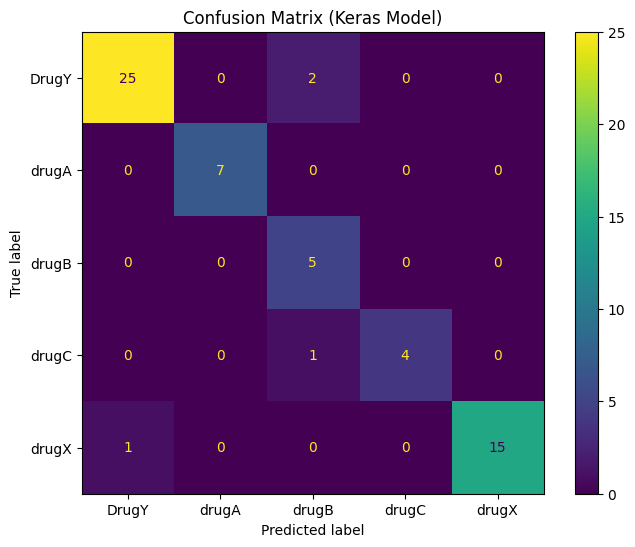

In [9]:
# Evaluate the Keras model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (Keras) = {accuracy * 100:.2f}%")

# Get predictions from the Keras model for plotting/matrix calculation
keras_predictions_probs = model.predict(X_test)
keras_predictions_indices = np.argmax(keras_predictions_probs, axis=1)

# Decode predictions from indices back to original labels for confusion matrix
reverse_label_mapping = {i: label for label, i in label_mapping.items()}
keras_predicted_labels = np.vectorize(reverse_label_mapping.get)(keras_predictions_indices)
test_true_labels = np.vectorize(reverse_label_mapping.get)(y_test)

# For the confusion matrix plot, we need the unique classes in their original string format
class_names = list(label_mapping.keys()) # Get class names from the mapping

# Calculate confusion matrix using decoded labels
cm = confusion_matrix(test_true_labels, keras_predicted_labels, labels=class_names)

# Plotting the confusion matrix
print("Generating confusion matrix plot...")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6)) # Adjust figure size if needed
disp.plot(ax=ax)
plt.title('Confusion Matrix (Keras Model)')
plt.savefig("Results/model_results.png", dpi=120)
print("Confusion matrix plot saved to Results/model_results.png")
plt.show()

In [10]:
# Write metrics to file
# Use the accuracy obtained directly from model.evaluate
print(f"Saving Accuracy to Results/metrics.txt: {accuracy:.4f}")
with open("Results/metrics.txt", "w") as outfile:
    # Note: F1 score for multi-class from quantized model is non-trivial to report here directly.
    # Reporting Keras accuracy as the primary metric for this updated pipeline step.
    outfile.write(f"\nTest Accuracy (Keras) = {accuracy:.4f}")
print("Metrics saved to Results/metrics.txt")

Saving Accuracy to Results/metrics.txt: 0.9333
Metrics saved to Results/metrics.txt
